# Time Series Modelling 

This notebook serves as a scratchpad for applying Bayesian Structural Time Series Models in Python using Tensorflow. https://www.tensorflow.org/probability/api_docs/python/tfp/sts

The options are numerous and I am certain they will continue to be expanded. I am utilizing the initial STS blog post https://blog.tensorflow.org/2019/03/structural-time-series-modeling-in.html and this nice tutorial https://juanitorduz.github.io/intro_sts_tfp/



In [1]:
# import necessary packages
import eia
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

import tensorflow as tf
import tensorflow_probability as tfp

api_key = "aa28e2f138eba77b131c6fe76cca8813"
api = eia.API(api_key)

In [2]:
# We are looking as Electricity demand in MISO in Megawatthours on a per hour basis
# reported in local time. 

MISO_dict = api.data_by_series(series='EBA.MISO-ALL.D.HL')

In [3]:
# First lets clean the data
MISO = pd.DataFrame(MISO_dict)
MISO.columns = ["MWh_Demand"] # rename column
MISO['Date'] = MISO.index # find it easier to work with column, but unnecessary
MISO['Date'] = MISO['Date'].str.replace(" ", '') # remove white space
MISO['Date'] = MISO['Date'].map(lambda x: str(x)[:-5]) # Remove timezone information
MISO['Date'] = pd.to_datetime(MISO['Date'], format = "%Y%m%dT%H") # Convert to Datetime index
MISO = MISO.set_index('Date') # set Date column as index
print(MISO.head(10))

                     MWh_Demand
Date                           
2015-07-01 01:00:00     67891.0
2015-07-01 02:00:00     65027.0
2015-07-01 03:00:00     63251.0
2015-07-01 04:00:00     62392.0
2015-07-01 05:00:00     63442.0
2015-07-01 06:00:00     66194.0
2015-07-01 07:00:00     69866.0
2015-07-01 08:00:00     73943.0
2015-07-01 09:00:00     77497.0
2015-07-01 10:00:00     80560.0


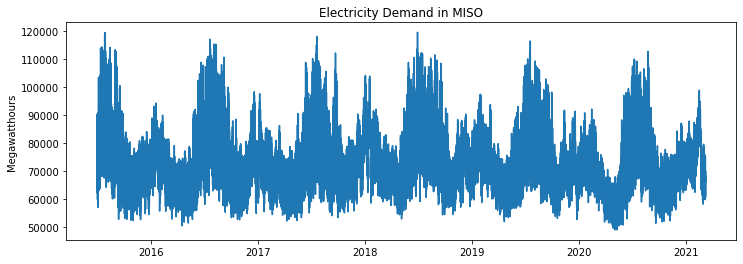

In [4]:
# Plot the Timeseries
plt.figure(figsize=(12, 4))
plt.plot(MISO['MWh_Demand'])
plt.title("Electricity Demand in MISO")
plt.ylabel("Megawatthours")
plt.show()

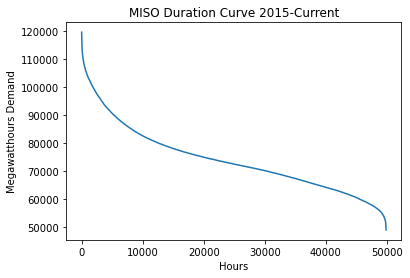

In [5]:
# Plot Duration Curve
MISO['MWh_Demand'].sort_values(ascending=False).reset_index(drop=True).plot()
plt.title("MISO Duration Curve 2015-Current")
plt.ylabel("Megawatthours Demand")
plt.xlabel("Hours")
plt.show()

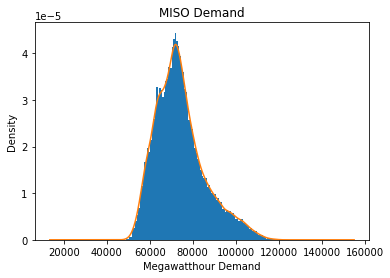

In [6]:
# Plot PDF
MISO['MWh_Demand'].plot.hist(bins=100, density=True)
MISO['MWh_Demand'].plot.density()
plt.xlabel("Megawatthour Demand")
plt.title("MISO Demand")
plt.show()

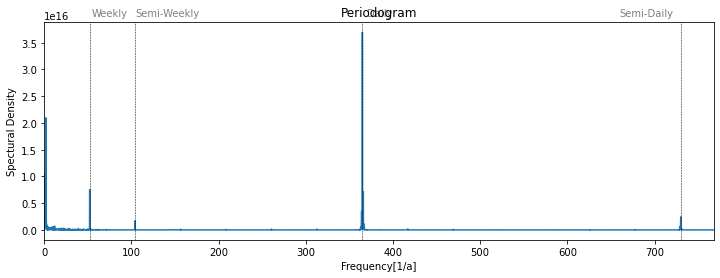

In [7]:
# Periodgram
# Need to forward fill in any missing data... fft does not hand na
MISO['MWh_Demand'] = MISO['MWh_Demand'].fillna(method='ffill')

# Use Fast Fourier Function
fft = abs(pd.Series(np.fft.rfft(MISO['MWh_Demand']- MISO['MWh_Demand'].mean()), #must subtract mean
                   index = np.fft.rfftfreq(len(MISO), d= 1./8760))**2) # 8760 is hours per year

# Plot
plt.figure(figsize=(12, 4))
fft.plot()
plt.xlim(0,768)
plt.xlabel('Frequency[1/a]') # x^-1 = 1/x
plt.ylabel("Spectural Density")
plt.title("Periodogram")

# add vertical lines for important Frequencies
plt.axvline(x=52, color='k', linestyle='--', linewidth = 0.5) # Week
plt.axvline(x=104, color='k', linestyle='--', linewidth = 0.5) # Semi-weekly
plt.axvline(x=365, color='k', linestyle='--', linewidth = 0.5) # Day
plt.axvline(x=730, color='k', linestyle='--', linewidth = 0.5) # Semi daily

# Add annotation
style = dict(size=10, color='gray')
plt.text(55, 4e16, "Weekly", **style)
plt.text(104, 4e16, "Semi-Weekly", **style)
plt.text(370, 4e16, "Daily", **style)
plt.text(660, 4e16, "Semi-Daily", **style)
plt.show()


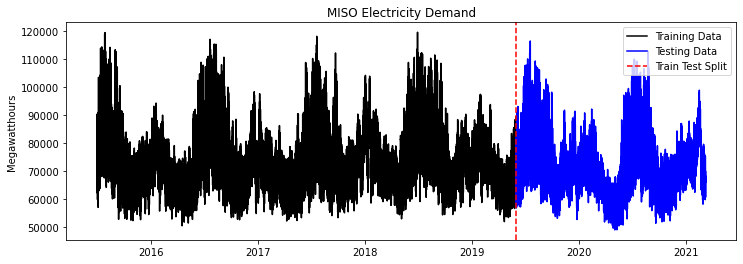

In [8]:
# Train_Test Split
# this is a good way to do this... should remember
threshold_date = pd.to_datetime("2019-06-01") # Split on June 1, 2019
mask = MISO.index < threshold_date

MISO_train = MISO[mask]
MISO_test = MISO[~ mask]

plt.figure(figsize = (12,4))
plt.plot(MISO_train, color = 'k', label = "Training Data")
plt.plot(MISO_test, color = 'b', label = "Testing Data")
plt.axvline(threshold_date, color = 'red', linestyle = "--",
            label = "Train Test Split")
plt.legend()
plt.title("MISO Electricity Demand")
plt.ylabel("Megawatthours")
plt.show()

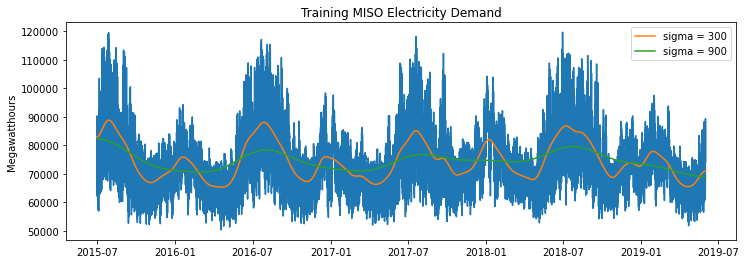

In [9]:
# Smoothing with a Gaussian Filter
# there are arguments that gaussian filters do a better job than moving avaerages in smoothing
# Gaussian filters weight data points by their distance from the current mean
# and assign almost no weight to data far from the mean
# controlled by the parameter sigma which is the standard deviation of the data

from scipy.ndimage import gaussian_filter

sigma1 = 300
sigma2 = 900

MISO_smooth = MISO_train \
    .assign(y_smooth_1 = lambda MISO_train: gaussian_filter(input=MISO_train['MWh_Demand'], sigma=300)) \
    .assign(y_smooth_2 = lambda MISO_train: gaussian_filter(input=MISO_train['MWh_Demand'], sigma=1500)) \

#print(MISO_smooth.head())

# Plot
plt.figure(figsize = (12,4))
plt.plot(MISO_smooth['MWh_Demand'])
plt.plot(MISO_smooth['y_smooth_1'], label = "sigma = {}".format(sigma1))
plt.plot(MISO_smooth['y_smooth_2'], label = "sigma = {}".format(sigma2))
plt.legend()
plt.title("Training MISO Electricity Demand")
plt.ylabel("Megawatthours")
plt.show()


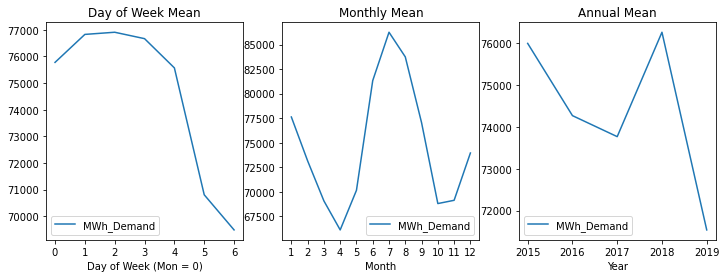

In [10]:
# We can also aggregate the data in different ways to gain understanding
fig, ax = plt.subplots(1,3, figsize = (12,4))

MISO_train.groupby(MISO_train.index.weekday).agg({'MWh_Demand':np.mean}).plot(ax=ax[0])
ax[0].set_title("Day of Week Mean")
ax[0].set_xticks(np.arange(0, 7, step=1))
ax[0].set_xlabel("Day of Week (Mon = 0)")

MISO_train.groupby(MISO_train.index.month).agg({'MWh_Demand':np.mean}).plot(ax=ax[1])
ax[1].set_title("Monthly Mean")
ax[1].set_xticks(np.arange(1, 13, step=1))
ax[1].set_xlabel("Month")


MISO_train.groupby(MISO_train.index.year).agg({'MWh_Demand':np.mean}).plot(ax=ax[2])
ax[2].set_title("Annual Mean")
ax[2].set_xlabel("Year")


plt.show()

<ipython-input-11-86915ad80b67>:4: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  MISO_train.column = ['MWh_Demand']


                     MWh_Demand
Date                           
2015-07-01 01:00:00     67891.0
2015-07-01 02:00:00     65027.0
2015-07-01 03:00:00     63251.0
2015-07-01 04:00:00     62392.0
2015-07-01 05:00:00     63442.0


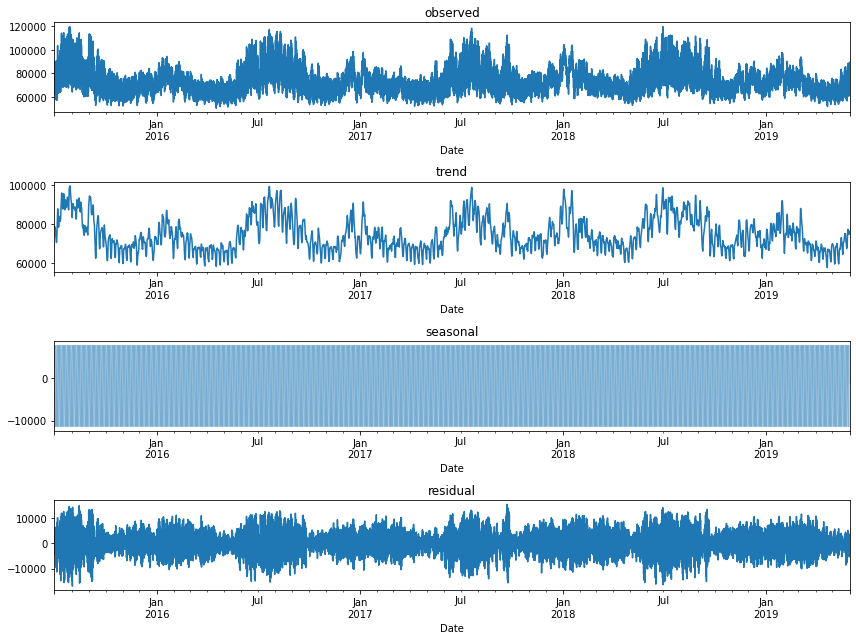

In [11]:
# Statsmodels has a built in seasonal decomposition tool which uses moving averages
from statsmodels.tsa.seasonal import seasonal_decompose

MISO_train.column = ['MWh_Demand']


# Missing data means frequency of the datetime index was not inferred...
# set the frequency manually and forward fill

MISO_train = MISO_train[~MISO_train.index.duplicated(keep='first')]
print(MISO_train.head())
MISO_train = MISO_train.asfreq("H", method = "ffill")
#MISO_train.columns = ['MWh_Demand']

MISO_train['MWh_Demand'] = MISO_train['MWh_Demand'].fillna(method='ffill')

MISO_train.columns = ['MWh_Demand']
decomposition = seasonal_decompose(MISO_train,
                                   model = 'additive')

print(decomposition)
fig, ax = plt.subplots(4, 1, figsize=(12, 9))
decomposition.observed.plot(ax=ax[0])
ax[0].set(title='observed')
decomposition.trend.plot(ax=ax[1])
ax[1].set(title='trend')
decomposition.seasonal.plot(ax=ax[2], linewidth=0.15)
ax[2].set(title='seasonal')
decomposition.resid.plot(ax=ax[3])
ax[3].set(title='residual')
plt.tight_layout()
plt.show()

In [12]:
# Define the model
# look here for guidance for day of month: https://www.tensorflow.org/probability/api_docs/python/tfp/sts/Seasonal
# maybe day of month is not necessary? maybe rather than month should just use week #

# look at parameter posterior. How to interpret? Maybe they are scale for uncertainy?
#  df_test['y_pred_std'] = forecast_scale

# Model Fit decomposition (last thing in Juans tutorial)

# Model Residual Analysis

# Model prediction

# Forecast error analysis

#------------

MISO_train['MWh_Demand'] = MISO_train['MWh_Demand'].astype(np.float32)


local_linear_trend = tfp.sts.LocalLinearTrend(
    observed_time_series=MISO_train['MWh_Demand'], 
    name='local_linear_trend',
)

num_days_per_month =  [
    [31, 28, 31, 30, 30, 31, 31, 31, 30, 31, 30, 31], #2015
    [31, 29, 31, 30, 30, 31, 31, 31, 30, 31, 30, 31], # 2016year with leap day.
    [31, 28, 31, 30, 30, 31, 31, 31, 30, 31, 30, 31], # 2017
    [31, 28, 31, 30, 30, 31, 31, 31, 30, 31, 30, 31], # 2018
    [31, 28, 31, 30, 30, 31, 31, 31, 30, 31, 30, 31] # 2019 has only 5 months
  ] 
 

num_hours_per_month = []

for year in num_days_per_month:
   
    l = []
    for month in year:
        l.append(month * 12)
    num_hours_per_month.append(l)
    
num_hours_per_month = np.array(num_hours_per_month)

In [ ]:

# Define month of year seasonal variable.
month_of_year = tfp.sts.Seasonal(
  num_seasons=12,
  num_steps_per_season=num_hours_per_month,
  name='month_of_year'
)

# Define day of week as seasonal variable.
day_of_week = tfp.sts.Seasonal(
    num_seasons=7, 
    num_steps_per_season=24,
    observed_time_series=MISO_train['MWh_Demand'], 
    name='day_of_week',
)

# Define hour of Day
hour_of_day = tfp.sts.Seasonal(
    num_seasons=24, 
    num_steps_per_season=1,
    observed_time_series=MISO_train['MWh_Demand'], 
    name='hour_of_day',
)

model_components = [
    local_linear_trend, 
    month_of_year, 
    day_of_week, 
    hour_of_day
]

toy_model = tfp.sts.Sum(
    components=model_components, 
    observed_time_series=MISO_train['MWh_Demand']
)

variational_posteriors = tfp.sts.build_factored_surrogate_posterior(
  model=toy_model, 
  seed=42
)


num_variational_steps = int(10)

# Set optimizer.
optimizer = tf.optimizers.Adam(learning_rate=0.1)

# Using fit_surrogate_posterior to build and optimize 
# the variational loss function.
@tf.function(experimental_compile=True)
def train():
    # Build the joint density. 
    target_log_prob_fn = toy_model.joint_log_prob(
        observed_time_series=MISO_train['MWh_Demand']
    )
    
    elbo_loss_curve = tfp.vi.fit_surrogate_posterior(
        target_log_prob_fn=target_log_prob_fn,
        surrogate_posterior=variational_posteriors,
        optimizer=optimizer,
        num_steps=num_variational_steps,
        seed=42
    )
    
    return elbo_loss_curve

# Run optimization.
elbo_loss_curve = train()

fig, ax = plt.subplots()
ax.plot(elbo_loss_curve, marker='.')
ax.set(title='ELBO Loss Curve', xlabel='iteration');

Instructions for updating:
Do not call `graph_parents`.
Instructions for updating:
`MultivariateNormalFullCovariance` is deprecated, use `MultivariateNormalTriL(loc=loc, scale_tril=tf.linalg.cholesky(covariance_matrix))` instead.
Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.
